### Problem 1 (50 points) 

Vapor-liquid equilibria data are correlated using two adjustable parameters $A_{12}$ and $A_{21}$ per binary
mixture. For low pressures, the equilibrium relation can be formulated as:

$$
\begin{aligned}
p = & x_1\exp\left(A_{12}\left(\frac{A_{21}x_2}{A_{12}x_1+A_{21}x_2}\right)^2\right)p_{water}^{sat}\\
& + x_2\exp\left(A_{21}\left(\frac{A_{12}x_1}{A_{12}x_1+A_{21}x_2}\right)^2\right)p_{1,4 dioxane}^{sat}.
\end{aligned}
$$

Here the saturation pressures are given by the Antoine equation

$$
\log_{10}(p^{sat}) = a_1 - \frac{a_2}{T + a_3},
$$

where $T = 20$($^{\circ}{\rm C}$) and $a_{1,2,3}$ for a water - 1,4 dioxane
system is given below.

|             | $a_1$     | $a_2$      | $a_3$     |
|:------------|:--------|:---------|:--------|
| Water       | 8.07131 | 1730.63  | 233.426 |
| 1,4 dioxane | 7.43155 | 1554.679 | 240.337 |


The following table lists the measured data. Recall that in a binary system $x_1 + x_2 = 1$.

|$x_1$ | 0.0 | 0.1 | 0.2 | 0.3 | 0.4 | 0.5 | 0.6 | 0.7 | 0.8 | 0.9 | 1.0 |
|:-----|:--------|:---------|:--------|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|
|$p$| 28.1 | 34.4 | 36.7 | 36.9 | 36.8 | 36.7 | 36.5 | 35.4 | 32.9 | 27.7 | 17.5 |

Estimate $A_{12}$ and $A_{21}$ using data from the above table: 

1. Formulate the least square problem; 
2. Since the model is nonlinear, the problem does not have an analytical solution. Therefore, solve it using the gradient descent or Newton's method implemented in HW1; 
3. Compare your optimized model with the data. Does your model fit well with the data?

---

### Problem 2 (50 points) 

Solve the following problem using Bayesian Optimization:
$$
    \min_{x_1, x_2} \quad \left(4-2.1x_1^2 + \frac{x_1^4}{3}\right)x_1^2 + x_1x_2 + \left(-4 + 4x_2^2\right)x_2^2,
$$
for $x_1 \in [-3,3]$ and $x_2 \in [-2,2]$. A tutorial on Bayesian Optimization can be found [here](https://thuijskens.github.io/2016/12/29/bayesian-optimisation/).





The value of A12 is  1.734258 and A21 is 1.6921307
0.00071549066


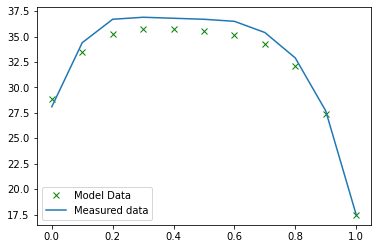

In [114]:
# Problem 1
import torch as t
from torch.autograd import Variable
import numpy as np
import math
import matplotlib.pyplot as plt
#Defining saturation pressure given by the Antoine equation
def psaturation(a):
    psat = a[0]
    psat -= a[1]/(20+a[2])
    psat = pow(10,psat)
    return psat
def lossfn(x,x1,x2,pw, p14d):
    loss = x1 * t.exp(x[0]*pow((x[1]*x2)/(x[0]*x1+x[1]*x2),2))*pw 
    loss+= x2 * t.exp(x[1]*pow((x[0]*x1)/(x[0]*x1+x[1]*x2), 2))*p14d
    return loss
#Defining a1,a2 & a3 for water 
aw = np.array([8.07131, 1730.63, 233.426])
#Defining a1,a2 & a3 for 1,4 dioxane system 
a14d = np.array([7.43155, 1554.679, 240.337])
pressure = np.array([28.1, 34.4, 36.7, 36.9, 36.8, 36.7, 36.5, 35.4, 32.9, 27.7, 17.5])
#Defining x1 
x1 = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
#Defining x2 
x2 = np.array([1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0])
pw = psaturation(aw)
p14d = psaturation(a14d)
x = Variable(t.tensor([1.5, 1.5]), requires_grad=True)

# Fix the step size
a = 0.001
num = 0;

# Start gradient descent
for i in range(100):  
    while num <= 10:
        loss = pow((lossfn(x, x1[num], x2[num],pw, p14d) - pressure[num]),2)
        loss.backward()
        num = num+1
    #x.grad.numpy()
    
    # no_grad() specifies that the operations within this context are not part of the computational graph, i.e., we don't need the gradient descent algorithm itself to be differentiable with respect to x
    with t.no_grad():
        x -= a * x.grad
        # need to clear the gradient at every step, or otherwise it will accumulate...
        x.grad.zero_()
A = x.data.numpy()       
print("The value of A12 is ", A[0], "and A21 is", A[1])
print(loss.data.numpy())

pcalc = []
num = 0
#calculating the values of p from estimated A12 and A21
while num <= 10:
    pcal = lossfn(x, x1[num], x2[num],pw, p14d)
    pcalc.append(pcal.data.numpy())
    num = num + 1 
#Plot both the data to compare the optimized model with the measured data
plt.plot(x1, pcalc,'gx',x1, pressure)
plt.legend(['Model Data','Measured data'])

The graph above compares the optimized model with the measured data

In [103]:
#Problem 2
import numpy as np 
from gp import*
#Defining the loss Function
def loss(x):
    x = -((4-2.1*pow(x[0],2)+pow(x[0],4)/3)*pow(x[0],2) + x[0]*x[1] + (4*pow(x[1],2) - 4)*pow(x[1],2))
    return x
#Defining the number of iterations
iterations = 10
#Defining the boundaries of x1 & x2
bounds = np.array([[-3, 3], [-2, 2]])
#Using Bayesian Optimization
x, y = bayesian_optimisation(iterations, loss, bounds)
print("At minimum point, x1 is", x[len(x1) -1][0], "and x2 is",x[len(x1) -1][1])
#Multiplying by -1 as we mutiplied by -1 in loss function
print("minimum value of given function is", -y[len(x1) -1])

At minimum point, x1 is 0.2127679016277324 and x2 is -0.7555763160290453
minimum value of given function is -0.9638497323196777
